In [1]:
pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K


In [3]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0 #convert pixel value to [0,1]
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28 * 28)) #reshape the flattened image
x_test = np.reshape(x_test, (-1, 28 * 28))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
input_shape = (28 * 28,) #tuple with one element of size 784=28*28
latent_dim = 2  # Dimension of the latent space
intermediate_dim = 256

	•	MNIST images are 28 × 28
	•	Dense layers cannot accept 2D images
	•	So we flatten each image into a vector

  	Latent space is where the model stores compressed information
	•	2 is not required, it’s chosen because:
	•	Easy to visualize
	•	You can literally plot it on a 2D graph
	•	In real models this is often 16, 32, 128, etc.

  What this does
	•	Number of neurons in the hidden layer

Why we do this
	•	The encoder must:
	•	Take 784 inputs
	•	Compress meaningful features
	•	256 is a capacity trade-off:
	•	Too small → loses information
	•	Too large → overfitting / pointless

#Encoder

In [5]:
inputs = Input(shape=input_shape, name='encoder_input') #creates input tensor (placeholder)
x = Dense(intermediate_dim, activation='relu')(inputs) #fully connected layer that applies ReLU - to extract non-linear features
z_mean = Dense(latent_dim, name='z_mean')(x) #latent distribution parameters
z_log_var = Dense(latent_dim, name='z_log_var')(x) #latent distribution parameters
#why - vae unlike others does not encode to fixed vector, but to probability distribution. log helps keep variance +ve
def sampling(args):  #receives distribution parameters
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0] #get batch size
    dim = tf.shape(z_mean)[1] #get latent dimension (dynamix cuz batch size changes during training)
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) #add randomness
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) #wraps sampling logic as a Keras Later
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder') # defines encoder as a standalone model
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling') #decoder expects 2D vector
x = Dense(intermediate_dim, activation='relu')(latent_inputs) #decoder hidden layer (expands compressed info back to features)
outputs = Dense(28 * 28, activation='sigmoid')(x) #sigmoid because pixels are normalized

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs) #initializes base keras model
        self.encoder = encoder #store prev models (no architecture change)
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss") # keras expects metrics objects. you want to see losses seperately

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ] #metrics that reset every epoch

    def train_step(self, data): # custom train space (robust)
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape: # manually computing loss
            z_mean, z_log_var, z = self.encoder(x) #encoder forward pass
            reconstruction = self.decoder(z) #decoder forward pass
            reconstruction_loss = tf.keras.ops.mean(
                binary_crossentropy(x, reconstruction) * 28 * 28
            ) #loss computed against inside train step
            kl_loss = -0.5 * (1 + z_log_var - tf.keras.ops.square(z_mean) - tf.keras.ops.exp(z_log_var)) #KL divergence loss
            kl_loss = tf.keras.ops.mean(tf.keras.ops.sum(kl_loss, axis=1)) #sum over latent dims and mean over batch
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) #backpropagation (manual)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        } #return logs

    def test_step(self, data): #validation should run forward pass, compute loss, not update weights
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        # Similar to train_step, but without gradient application
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.keras.ops.mean(
            binary_crossentropy(x, reconstruction) * 28 * 28
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.keras.ops.square(z_mean) - tf.keras.ops.exp(z_log_var))
        kl_loss = tf.keras.ops.mean(tf.keras.ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs): #for prediction/inference
        # This call method is used for inference, not for training step
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

vae = VAE(encoder, decoder) #compile
vae.compile(optimizer='adam', loss='mse')
vae.summary()

Model: "vae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 2), (None, 2), │       201,988 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       202,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - kl_loss: 6.1615 - loss: 149.0965 - reconstruction_loss: 142.9351 - val_kl_loss: 6.1489 - val_loss: 152.9919 - val_reconstruction_loss: 146.8430
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 6.1889 - loss: 149.4652 - reconstruction_loss: 143.2764 - val_kl_loss: 6.1159 - val_loss: 152.8094 - val_reconstruction_loss: 146.6934
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 6.1778 - loss: 149.3050 - reconstruction_loss: 143.1272 - val_kl_loss: 6.2265 - val_loss: 152.8837 - val_reconstruction_loss: 146.6573
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 6.1896 - loss: 148.9996 - reconstruction_loss: 142.8101 - val_kl_loss: 6.2289 - val_loss: 152.8871 - val_reconstruction_loss: 146.6582
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 6.1999 - loss: 149.1737 - reconstruction_loss: 142.9737 - val_kl_loss: 6.2668 - val_loss: 152.5173 - val_reconstruction_loss: 146.2505
Epoch 6/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

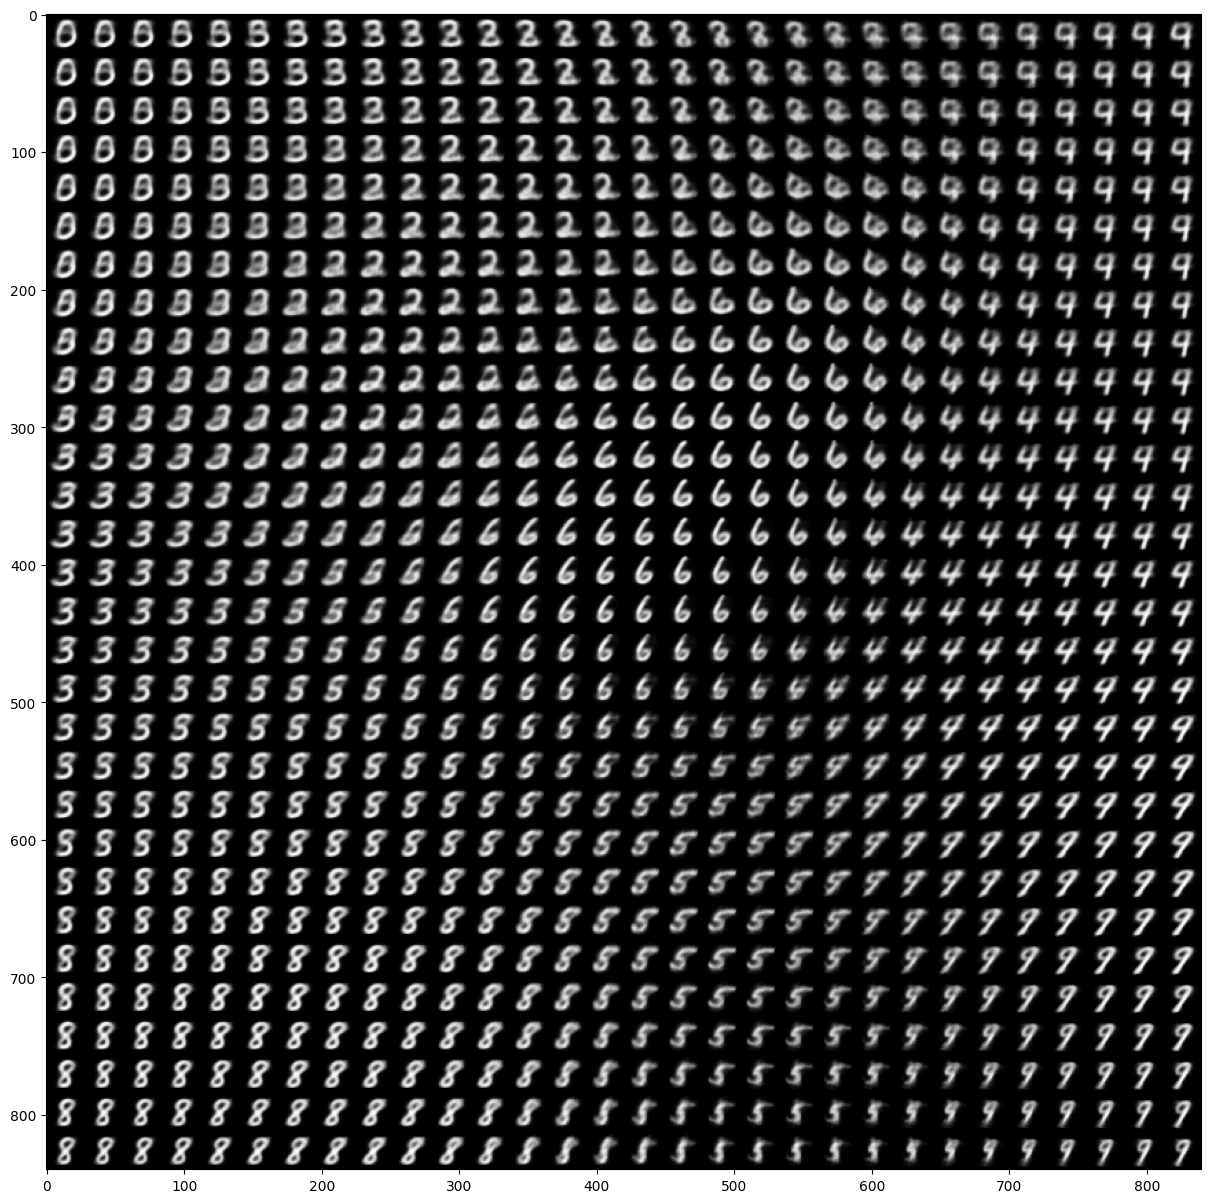

In [24]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
plot_latent_space(vae)


Explanation
Data Loading and Preprocessing: MNIST dataset is loaded and normalized.
Each image is flattened into a 784-dimensional vector.
VAE Parameters: Define the input shape, latent dimension, and intermediate dimension.
Encoder: Maps input data to a latent space (mean and log variance).
Sampling Layer: Generates a latent vector by sampling from the latent space using the reparameterization trick.
Decoder: Maps the latent vector back to the original data space.
VAE Model: Combines the encoder and decoder. The loss function includes reconstruction loss and KL divergence.
Training: The model is trained on the MNIST dataset.
Image Generation: Generates new images by sampling from the latent space.
This simple VAE implementation can be extended and modified for more complex datasets and use

# Fashion MNIST DATASET
